# Exploratory data analysis

#### Import libraries

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
sns.set()
sns.set_palette('husl')

In [2]:
import numpy as np
import pandas as pd
import re
import string
from collections import defaultdict
import nltk
from nltk.corpus import stopwords
import stop_words

from pymystem3 import Mystem

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [3]:
import warnings
warnings.simplefilter('ignore')

#### Load and prepare dataset

#### Source of data:
https://www.kaggle.com/yutkin/corpus-of-russian-news-articles-from-lenta/

In [4]:
%%time
data = pd.read_csv('./data/lenta-ru-news.csv', parse_dates=['date'])

Wall time: 1min


In [5]:
# the first row
data.iloc[0].values

array(['https://lenta.ru/news/1914/09/16/hungarnn/',
       '1914. Русские войска вступили в\xa0пределы Венгрии  ',
       'Бои у Сопоцкина и Друскеник закончились отступлением германцев. Неприятель, приблизившись с севера к Осовцу начал артиллерийскую борьбу с крепостью. В артиллерийском бою принимают участие тяжелые калибры. С раннего утра 14 сентября огонь достиг значительного напряжения. Попытка германской пехоты пробиться ближе к крепости отражена. В Галиции мы заняли Дембицу. Большая колонна, отступавшая по шоссе от Перемышля к Саноку, обстреливалась с высот нашей батареей и бежала, бросив парки, обоз и автомобили. Вылазки гарнизона Перемышля остаются безуспешными. При продолжающемся отступлении австрийцев обнаруживается полное перемешивание их частей, захватываются новые партии пленных, орудия и прочая материальная часть. На перевале Ужок мы разбили неприятельский отряд, взяли его артиллерию и много пленных и, продолжая преследовать, вступили в пределы Венгрии. \n«Русский инвали

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800975 entries, 0 to 800974
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   url     800975 non-null  object        
 1   title   800975 non-null  object        
 2   text    800970 non-null  object        
 3   topic   738973 non-null  object        
 4   tags    773756 non-null  object        
 5   date    800975 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 36.7+ MB


In [7]:
# missing data
round((len(data) - data.count()) / len(data) * 100, 2).sort_values(ascending=False)

topic    7.74
tags     3.40
date     0.00
text     0.00
title    0.00
url      0.00
dtype: float64

In [8]:
# number of categories
data.nunique().sort_values(ascending=False)

url      800964
text     800037
title    797832
date       7393
tags         94
topic        23
dtype: int64

#### Tags

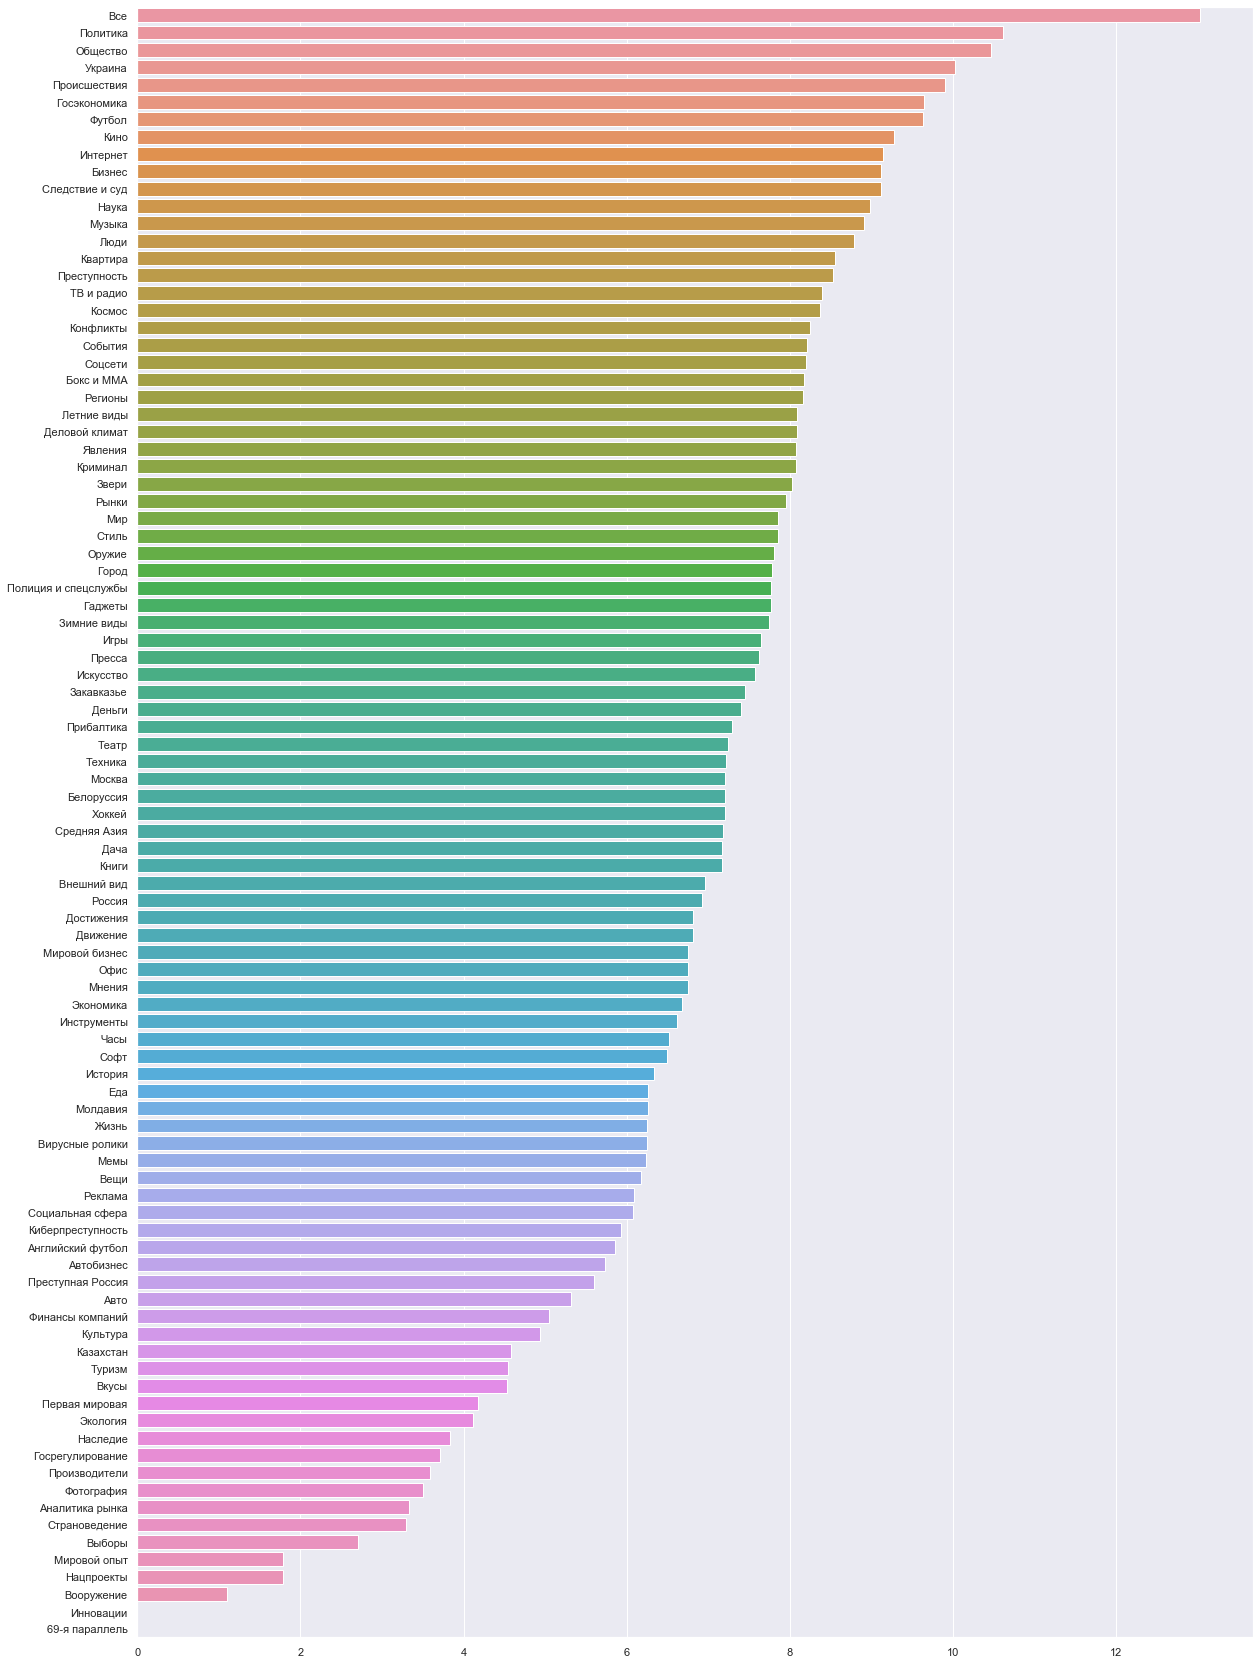

In [9]:
# log because the difference between most common and most unpopular tags is enourmous
plt.figure(figsize=(20,30))
sns.barplot(x=np.log(data.tags.value_counts().values), y=data.tags.value_counts().index);

#### Topics

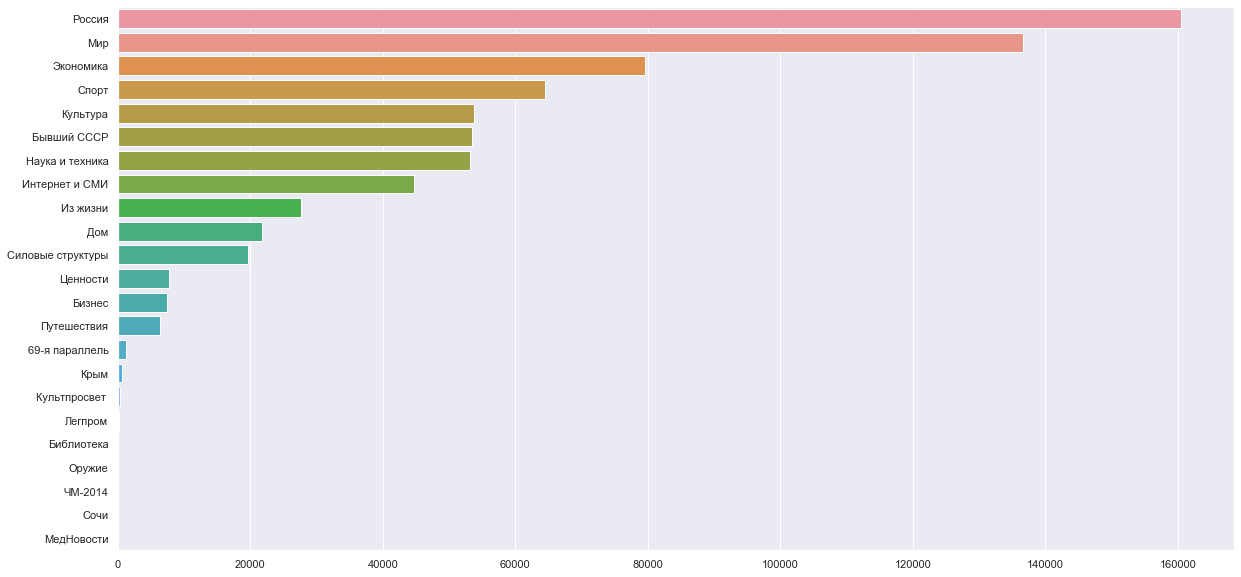

In [10]:
plt.figure(figsize=(20,10))
sns.barplot(x=data.topic.value_counts().values, y=data.topic.value_counts().index);

In [11]:
table = pd.crosstab(data.tags, data.topic)
table

topic,69-я параллель,Библиотека,Бизнес,Бывший СССР,Дом,Из жизни,Интернет и СМИ,Крым,Культпросвет,Культура,...,Наука и техника,Оружие,Путешествия,Россия,Силовые структуры,Сочи,Спорт,Ценности,ЧМ-2014,Экономика
tags,,,,,,,,,,,,,,,,,,,,,
Coцсети,0,0,0,0,0,0,2924,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Авто,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,141,0,0,0
Автобизнес,0,0,310,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Аналитика рынка,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Белоруссия,0,0,0,916,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Футбол,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,13128,0,0,0
Хоккей,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,915,0,0,0
Часы,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,662,0,0


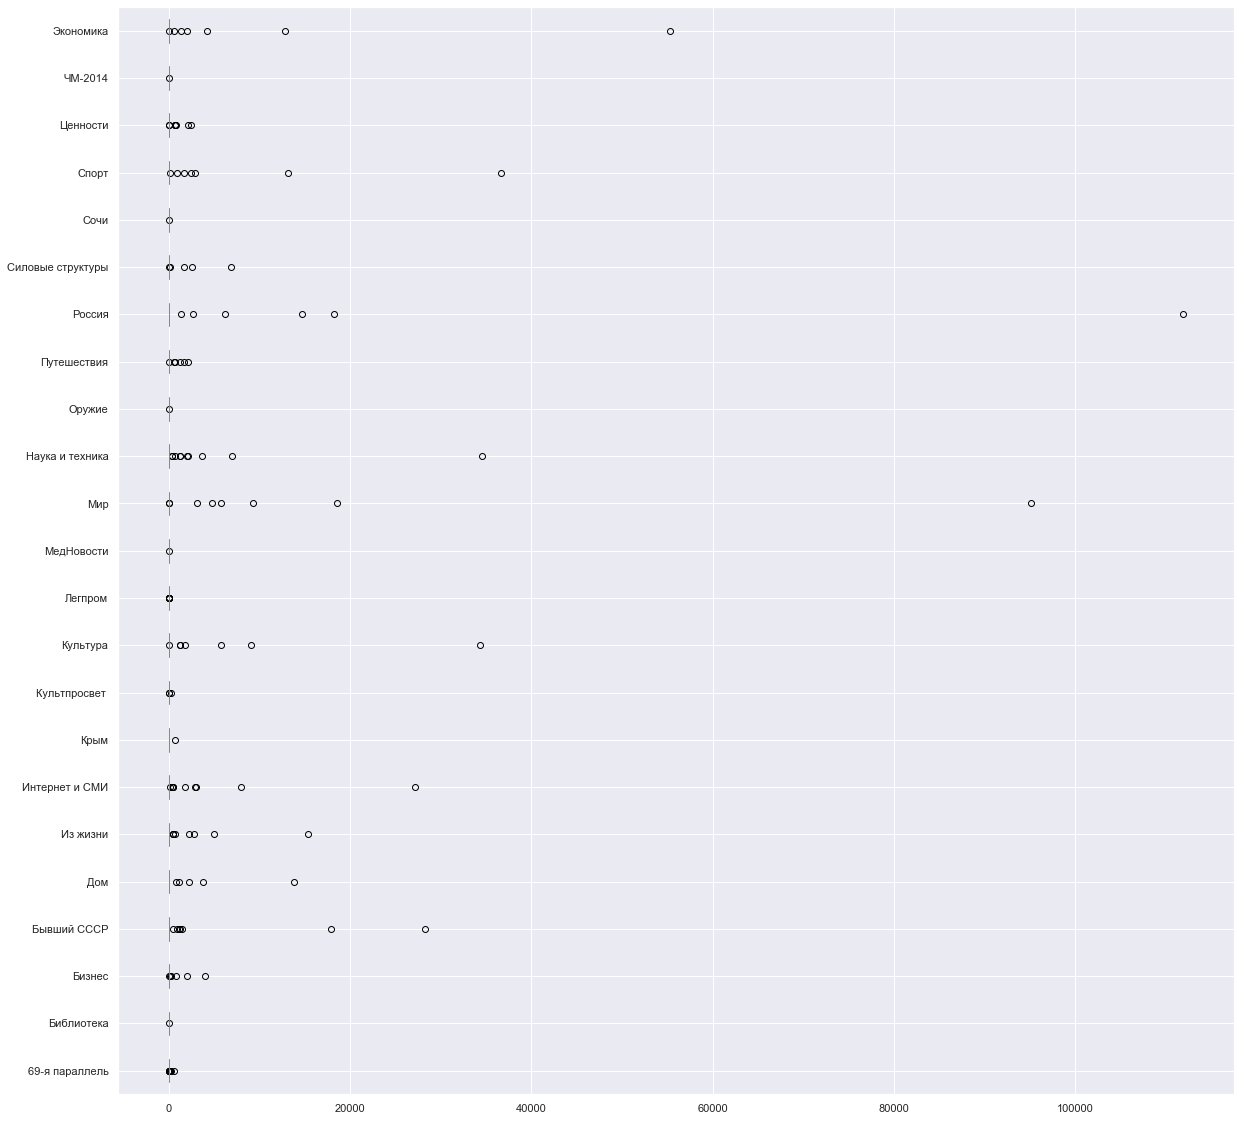

In [12]:
plt.figure(figsize=(20,20))
table.boxplot(vert=False);

In [13]:
data.text = data.text.str.lower()

In [18]:
STOPWORDS = set(stop_words.get_stop_words('ru'))
PUNCT = set(string.punctuation)

In [19]:
%%time
# word_count
data['word_count'] = data['text'].apply(lambda x: len(str(x).split()))

# unique_word_count
data['unique_word_count'] = data['text'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
data['stop_word_count'] = data['text'].apply(lambda x: len([w for w in str(x).split() if w in STOPWORDS]))

# mean_word_length
data['mean_word_length'] = data['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
data['char_count'] = data['text'].apply(lambda x: len(str(x)))

# punctuation_count
data['punctuation_count'] = data['text'].apply(lambda x: len([c for c in str(x) if c in PUNCT]))

Wall time: 9min 23s


### Anomaly detection

In [20]:
data.describe()

,word_count,unique_word_count,stop_word_count,mean_word_length,char_count,punctuation_count
count,800975.000000,800975.000000,800975.000000,800975.000000,800975.000000,800975.000000
mean,180.299001,142.868159,50.503455,6.408243,1332.301240,36.077064
std,73.708870,48.919109,23.423806,0.483442,548.050084,18.506127
min,1.000000,1.000000,0.000000,2.500000,3.000000,0.000000
25%,133.000000,110.000000,35.000000,6.115385,978.000000,25.000000
50%,170.000000,137.000000,47.000000,6.395455,1254.000000,33.000000
75%,216.000000,170.000000,62.000000,6.680251,1599.000000,43.000000
max,8092.000000,3716.000000,3159.000000,50.000000,55387.000000,1799.000000


Obviously there are some outlyers in the dataset.

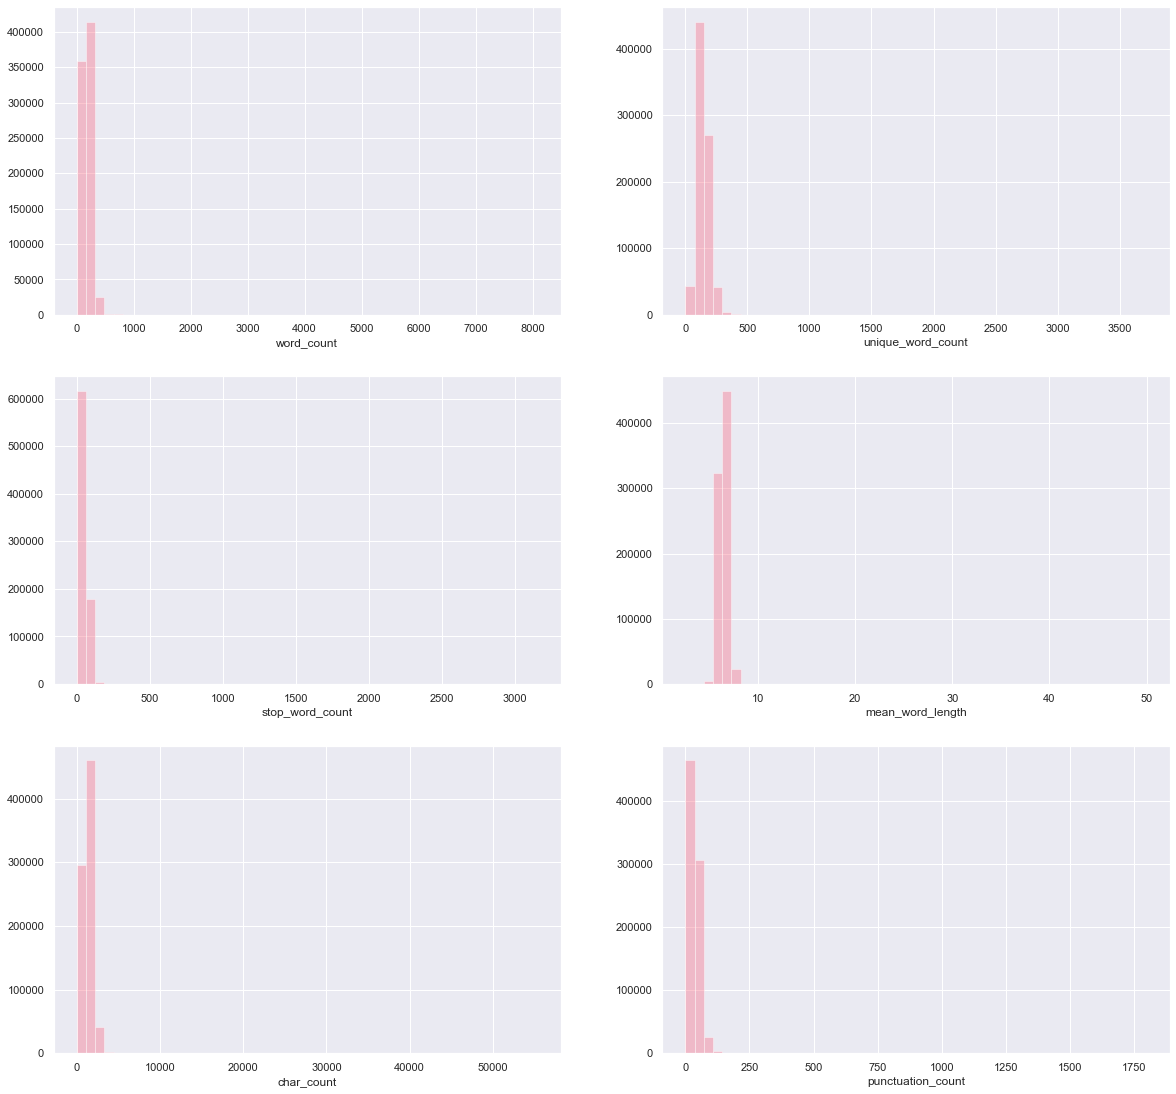

In [21]:
METAFEATURES = ['word_count', 
                'unique_word_count', 
                'stop_word_count', 
                'mean_word_length',
                'char_count', 
                'punctuation_count']
  
plt.figure(figsize=(20,60))

for i, colname in enumerate(METAFEATURES):
    plt.subplot(9,2,i+1)
    sns.distplot(data[colname], kde=False)
    
plt.show()

In [22]:
data['word_count'].quantile(0.01), data['word_count'].quantile(0.99)

(56.0, 395.0)

In [23]:
data['mean_word_length'].quantile(0.01), data['mean_word_length'].quantile(0.99)

(5.449049508692366, 7.506270569620254)

In [24]:
data['punctuation_count'].quantile(0.01), data['punctuation_count'].quantile(0.99)

(10.0, 96.0)

In [25]:
data = data.loc[data['word_count'].between(
    data['word_count'].quantile(0.01), data['word_count'].quantile(0.99)
)]

In [26]:
data = data.loc[data['mean_word_length'].between(
    data['mean_word_length'].quantile(0.01), data['mean_word_length'].quantile(0.99)
)]

In [27]:
data = data.loc[data['punctuation_count'].between(
    data['punctuation_count'].quantile(0.01), data['punctuation_count'].quantile(0.99)
)]

In [29]:
data.shape

(755939, 12)

In [28]:
data.to_csv('train_data.csv', index=False)